## Adult Census

In [1]:
from sklearn.datasets import fetch_openml

X_adult, y_adult = fetch_openml("adult", version=2, return_X_y=True)
# drop redundant or non-feature columns
X_adult = X_adult.drop(["education-num", "fnlwgt"], axis="columns")

In [2]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score

early_stopping_params = dict(
    early_stopping=True,
    max_iter=10_000,
    n_iter_no_change=5, 
)

hgbc = HistGradientBoostingClassifier(
    categorical_features="from_dtype",
    **early_stopping_params,
)

hgbc_adult_scores = cross_val_score(hgbc, X_adult, y_adult, cv=5, n_jobs=8)

CPU times: user 162 ms, sys: 76.1 ms, total: 238 ms
Wall time: 2.02 s


In [3]:
def print_accuracy(cv_scores):
    print(f"Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

print_accuracy(hgbc_adult_scores)

Accuracy: 0.873 ± 0.002


In [4]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.neural_network import MLPClassifier

max_dim_per_feature = 50
sparse_output = True
mlp_preproc = ColumnTransformer(
    [
        (
            "cat",
             OneHotEncoder(
                max_categories=max_dim_per_feature,
                handle_unknown="infrequent_if_exist",
                sparse_output=sparse_output,
            ),
            make_column_selector(dtype_include="category"),
        ),
        (
            "num",
            SplineTransformer(
                n_knots=max_dim_per_feature,
                sparse_output=sparse_output,
            ),
            make_column_selector(dtype_include="number"),
        ),
    ],
)
mlpc = make_pipeline(
    mlp_preproc,
    MLPClassifier(
        hidden_layer_sizes=[256] * 4,
        **early_stopping_params,
    ))
mlp_adult_scores = cross_val_score(mlpc, X_adult, y_adult, cv=5, n_jobs=8)

CPU times: user 83.8 ms, sys: 26.4 ms, total: 110 ms
Wall time: 17.7 s


In [5]:
print_accuracy(mlp_adult_scores)

Accuracy: 0.863 ± 0.003


The GBDT number match the performance reported in the AD column of Table 6 of:

https://arxiv.org/abs/2203.05556

The MLP with OneHot + Spline Feature are not too far from the state of the art for numerical feature embeddings:

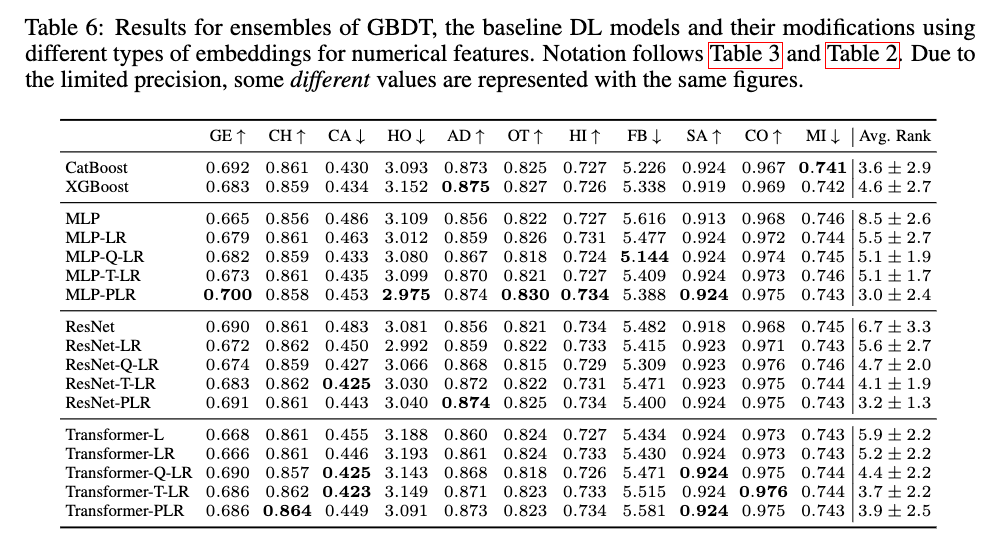

Replacing the `SplineTransformer` features by `StandardScaler` or reducing `n_knots` would typically result in a degration of 1 or 2% accuracy on this dataset. The axis-aligned inductive prior of spline features with a large number of knots seems to be useful here.

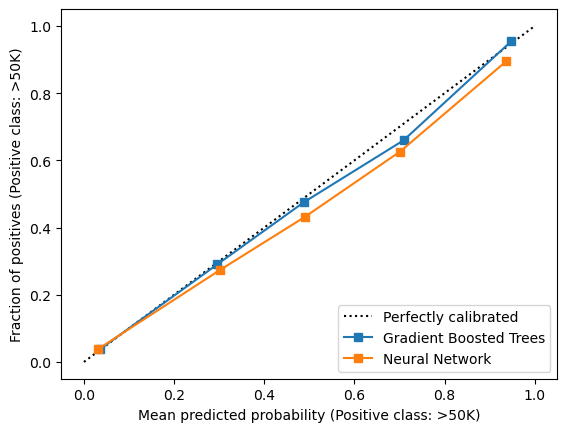

In [6]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split


def plot_calibration(hgbc, mlp, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5)

    fig, ax = plt.subplots()
    _ = CalibrationDisplay.from_estimator(
        hgbc.fit(X_train, y_train),
        X_val,
        y_val,
        name="Gradient Boosted Trees",
        ax=ax,
    )
    _ = CalibrationDisplay.from_estimator(
        mlp.fit(X_train, y_train),
        X_val,
        y_val,
        name="Neural Network",
        ax=ax,
    )

plot_calibration(hgbc, mlpc, X_adult, y_adult)

Both models can be reasonably calibrated by default as long as using early stopping for both. Without early stopping a validation logloss, both can get significantly over-confident if `max_iter` is too large.

## California Housing

In [7]:
from sklearn.datasets import fetch_california_housing

X_cal, y_cal = california_housing = fetch_california_housing(
    as_frame=True, return_X_y=True
)

In [8]:
%%time
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor


hgbr = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_features=0.8,
    max_leaf_nodes=16,
    **early_stopping_params,
)

hgbr_cal_scores = cross_val_score(
    hgbr, X_cal, y_cal, cv=5, n_jobs=8, scoring="neg_mean_squared_error"
)

CPU times: user 10.5 ms, sys: 5.92 ms, total: 16.4 ms
Wall time: 2.91 s


In [9]:
def print_rmse(cv_scores):
    cv_scores = np.sqrt(-cv_scores)
    print(f"RMSE: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

print_rmse(hgbr_cal_scores)

RMSE: 0.611 ± 0.042


In [10]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

mlpr = make_pipeline(
    # SplineTransformer with large n_knots does not work well here,
    # using a simpler standard scaler instead.
    StandardScaler(),
    MLPRegressor(
        hidden_layer_sizes=[256] * 4,
        **early_stopping_params,
    ))

mlpr_cal_scores = cross_val_score(
    mlpr, X_cal, y_cal, cv=5, n_jobs=8, scoring="neg_mean_squared_error"
)

CPU times: user 30.7 ms, sys: 19.4 ms, total: 50.1 ms
Wall time: 18.3 s


In [11]:
print_rmse(mlpr_cal_scores)

RMSE: 0.609 ± 0.042


The MLP on scaled features seems to be much better than on spline features, the axis-aligned inductive bias seems to be counter-productive for this dataset, although the tree model get a similar predictive performance.

However, I do not reproduce the RMSE numbers from Gorishniy et al, 2023, despite some (manual) hparam tuning attempts. I suspect a different scaling of the target.